In [1]:
import sys # scriptをimportする
sys.path.append('../scripts/')
from robot import * # robot.py
from scipy.stats import multivariate_normal # 多変量ガウス分布を扱う
from matplotlib.patches import Ellipse # 楕円描画

In [2]:
# 誤差楕円の描画
# p=ロボットのpose
# cov=ロボットの信念の分散共分散行列
# n =nシグマ範囲
def sigma_ellipse(p, cov, n): 
    # 分散共分散行列の固有値、固有値ベクトル
    eig_vals, eig_vec = np.linalg.eig(cov)
    # 誤差楕円の方向を計算
    ang = math.atan2(eig_vec[:,0][1], eig_vec[:,0][0])/math.pi*180
    # 楕円オブジェクト
    # width, heightは標準偏差 * シグマ範囲
    # fill=塗りつぶし
    # color=色
    # alpha=透明度
    return Ellipse(p, width=n*math.sqrt(eig_vals[0]),height=n*math.sqrt(eig_vals[1]), angle=ang, fill=False, color="blue", alpha=0.5)

In [3]:
class KalmanFilter:
    # envmap=地図情報(ランドマーク位置)
    # init_pose=ロボットの信念の初期位置姿勢
    # motion_noise_stds=移動時の雑音の標準偏差(詳細はKfAgentに記述)
    # distance_dev_rate=距離あたりの距離の観測値の雑音の標準偏差
    # direction_dev=方角の観測値の雑音の標準偏差
    def __init__(self, envmap, init_pose, motion_noise_stds, distance_dev_rate=0.14, direction_dev=0.05):
        # belief=信念の多変量ガウス分布
        # mean=信念の中心
        # cov=信念の分散共分散行列
        self.belief = multivariate_normal(mean=init_pose, \
                                        cov=np.diag([1e-10, 1e-10, 1e-10]))
        # 初期値
        self.motion_noise_stds = motion_noise_stds
        self.map = envmap
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev
        
    def observation_update(self, observation):
        # ランドマークの観測
        for d in observation:
            z = d[0]      # 観測結果
            obs_id = d[1] # 観測したランドマークのID
            
            ###Hの計算###
            # 地図上のランドマークの位置
            mx, my = self.map.landmarks[obs_id].pos
            # 信念(の中心)
            mux, muy, mut = self.belief.mean
            # ランドマークと信念の距離
            q = (mux - mx)**2 + (muy - my)**2
            sqrtq = np.sqrt(q)
            # H=観測モデルh(x)を線形化するための行列
            H = np.array([[(mux - mx)/sqrtq, (muy - my)/sqrtq, 0.0],  [(my - muy)/q, (mux - mx)/q, -1.0]])
            
            ###Qの計算###
            # 信念とランドマーク間の距離と方角を算出
            hmu = IdealCamera.relative_polar_pos(self.belief.mean, self.map.landmarks[obs_id].pos)
            # 観測距離の標準偏差
            distance_dev = self.distance_dev_rate*hmu[0]
            # 観測値の共分散行列
            Q = np.diag(np.array([distance_dev**2, self.direction_dev**2]))
            
            ###カルマンゲインの計算###
            # K=観測値の共分散行列と信念の共分散行列から、観測後の信念の移動量を決めるゲイン
            # 観測値の共分散行列が小さいほど観測値を優先するようになる
            K = self.belief.cov.dot(H.T).dot(np.linalg.inv(Q + H.dot(self.belief.cov).dot(H.T)))
            
            ###更新###
            # 観測後の信念
            self.belief.mean += K.dot(z - hmu)
            # 観測後の信念の共分散行列
            self.belief.cov = (np.eye(3) - K.dot(H)).dot(self.belief.cov)
        
    def motion_update(self, nu, omega, time):
        if abs(omega) < 1e-5: omega = 1e-5   #0だとガウス分布が作れないのでごくわずかな値を入れる
        if abs(nu) < 1e-5:         nu = 1e-5 #0だとガウス分布が作れないのでごくわずかな値を入れる

        v = self.motion_noise_stds
        # 移動モデルの雑音の共分散行列
        M = np.diag([v["nn"]**2*abs(nu)/time + v["no"]**2*abs(omega)/time, 
                     v["on"]**2*abs(nu)/time + v["oo"]**2*abs(omega)/time])
        
        # 現在の信念の姿勢
        t = self.belief.mean[2]
        # 移動前のsinとcosの計算
        st, ct = math.sin(t), math.cos(t)
        # 角速度から、移動後のsinとcosを計算
        stw, ctw = math.sin(t + omega*time), math.cos(t + omega*time)
        # A=状態遷移行列
        A = np.array([[(stw - st)/omega,    -nu/(omega**2)*(stw - st) + nu/omega*time*ctw],
                                 [(-ctw + ct)/omega, -nu/(omega**2)*(-ctw + ct) + nu/omega*time*stw],
                                 [0,                                time]] )
        # 状態遷移関数f()を線形化するための行列
        # 偏微分により近似
        F = np.diag([1.0, 1.0, 1.0])
        F[0, 2] = nu / omega * (math.cos(t + omega * time) - math.cos(t))
        F[1, 2] = nu / omega * (math.sin(t + omega * time) - math.sin(t))
            
        # 移動後の信念を更新
        self.belief.cov = F.dot(self.belief.cov).dot(F.T) + A.dot(M).dot(A.T)
        self.belief.mean = IdealRobot.state_transition(nu, omega, time, self.belief.mean)
        
    def draw(self, ax, elems):
        ###xy平面上の誤差の3シグマ範囲###
        e = sigma_ellipse(self.belief.mean[0:2], self.belief.cov[0:2, 0:2], 3)
        elems.append(ax.add_patch(e))

        ###θ方向の誤差の3シグマ範囲###
        x, y, c = self.belief.mean
        sigma3 = math.sqrt(self.belief.cov[2, 2])*3
        xs = [x + math.cos(c-sigma3), x, x + math.cos(c+sigma3)]
        ys = [y + math.sin(c-sigma3), y, y + math.sin(c+sigma3)]
        elems += ax.plot(xs, ys, color="blue", alpha=0.5)

In [4]:
class KfAgent(Agent): 
    # time_interval=周期[s]
    # nu=並進速度[m/s]
    # omega=角速度[rad/s]
    # init_pose=初期位置姿勢(x, y, t)
    # envmap=地図情報(ランドマークの位置)
    # motion_noise_stds=移動のばらつきの標準偏差
    ## nn=直進 1[m] あたりに生じる直進方向のばらつきの標準偏差
    ## no=回転 1[rad] あたりに生じる直進方向のばらつきの標準偏差
    ## on=直進 1[m] あたりに生じる回転方向のばらつきの標準偏差
    ## oo=回転 1[rad] あたりに生じる回転方向のばらつきの標準偏差
    def __init__(self, time_interval, nu, omega, init_pose, envmap, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        # 親クラスAgentより継承
        super().__init__(nu, omega)
        # カルマンフィルタクラスのインスタンス化
        self.kf = KalmanFilter(envmap, init_pose, motion_noise_stds) 
        
        self.time_interval = time_interval
        
        # 前ステップの並進速度と角速度初期値
        self.prev_nu = 0.0
        self.prev_omega = 0.0
        
    def decision(self, observation=None):
        # 移動後の信念の更新
        self.kf.motion_update(self.prev_nu, self.prev_omega, self.time_interval) 
        # 並進速度と角速度を保存
        self.prev_nu, self.prev_omega = self.nu, self.omega
        # 観測後の信念の更新
        self.kf.observation_update(observation)
        # 現在の速度と角速度を返す
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.kf.draw(ax, elems)

<IPython.core.display.Javascript object>


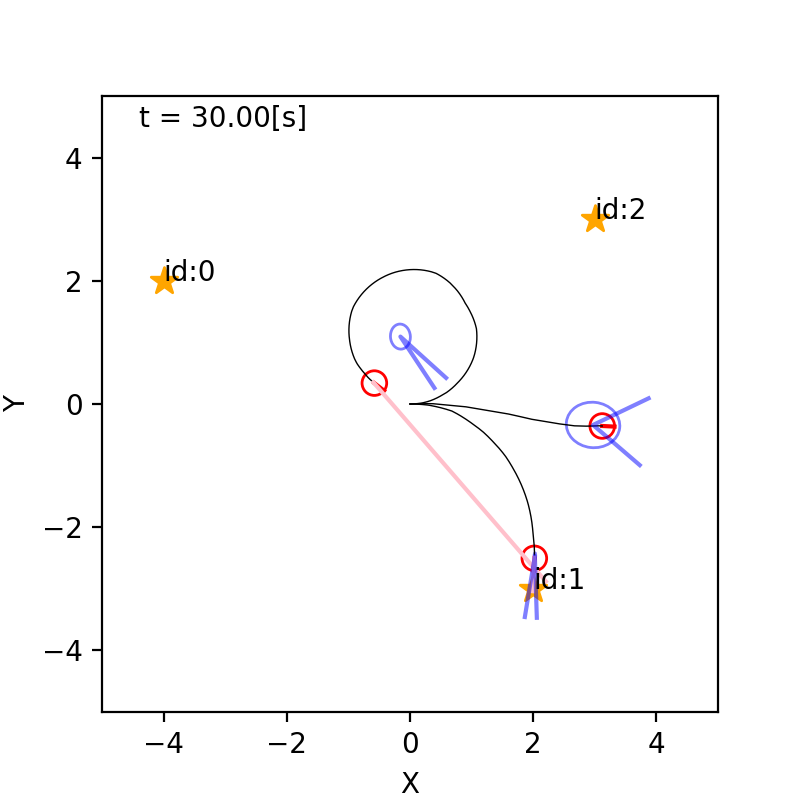

In [5]:
if __name__ == '__main__': 
    # シミュレーションの周期[s]
    time_interval = 0.1
    # ワールド作成、time_span=30[s]、World() -> (../scripts/ideal_robot.py)
    world = World(30, time_interval) 
    # 30.0 / 0.1 = 300回ワールドが更新される

    ### 3つのランドマークがある地図を生成 ###
    # Map() -> (../scripts/ideal_robot.py)
    m = Map()             
    # ランドマークを設置、Landmark() -> (../scripts/ideal_robot.py)
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    # ワールドにマップ情報を追加
    world.append(m)          

    
    ### ロボットを作る ###
    # circling=左旋回するロボット
    # 並進速度=0.2[m/s]、角速度=10.0[deg/s]、初期位置(x,y,theta)=(0,0,0)、m = Map()
    circling = KfAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T, m)
    # ロボットを作成
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=circling, color="red")
    # ワールドにロボットを追加
    world.append(r)
  

    # linear=前進するロボット
    # 並進速度=0.1[m/s]、角速度=0[deg/s]、初期位置(x,y,theta)=(0,0,0)、m = Map()
    linear = KfAgent(time_interval, 0.1, 0.0, np.array([0, 0, 0]).T, m)
    # ロボットを作成
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=linear, color="red")
    # ワールドにロボットを追加
    world.append(r)
 

    # right=右旋回するロボット
    # 並進速度=0.1[m/s]、角速度=-3.0[deg/s]、初期位置(x,y,theta)=(0,0,0)、m = Map()
    right = KfAgent(time_interval, 0.1, -3.0/180*math.pi, np.array([0, 0, 0]).T, m)
    # ロボットを作成
    r = Robot(np.array([0, 0, 0]).T, sensor=Camera(m), agent=right, color="red")
    # ワールドにロボットを追加
    world.append(r)

    
    # ワールドを描画
    world.draw()                       # アニメーションさせるとき
   # r.one_step(time_interval)  # アニメーションなしでデバッグするとき